## Create DataLoader for VisDrone2019-DET-val


In [55]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader


def get_image(image_path):
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

def get_annotation(image_path):
  annot_path = image_path[0:image_path.rfind('.')] + '.txt'
  annot_path = annot_path.replace('/images', '/annotations')
  categories = {}

  with open(annot_path) as f:
    for line in f.readlines():
      coords = list(map(int, line.split(',')))
      x, y, w, h, score, category, truncation, occlusion = coords
      categories.setdefault(category, [])
      categories[category].append((x, y, w, h))

  return categories

def show_image(image, annotations=[], title=None, display=True):
  img = image.copy()
  for x, y, w, h in annotations:
    # obj = img[y:y+h, x:x+w]
    img = cv2.rectangle(img, [x, y], [x+w, y+h], color=(255, 0, 0), thickness=4)

  plt.title(title)
  plt.axis('off')
  plt.imshow(img)
  if display:
    plt.show()

def calc_overlap(rect1, rect2):
  (x1, y1, w1, h1), (x2, y2, w2, h2) = rect1, rect2
  x_left, y_top = max(x1, x2), max(y1, y2)
  x_right, y_bottom = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)

  if x_right <= x_left or y_bottom <= y_top:
      return 0.0  # No overlap

  intersection = (x_right - x_left) * (y_bottom - y_top)
  return max(intersection / (w1 * h1), intersection / (w2 * h2))

def add_object(img, obj, y, x):
  h_, w_ = obj.shape[0:2]
  center = (x + w_ // 2, y + h_ // 2)
  mask = None
  return cv2.seamlessClone(obj, img, mask, center, cv2.NORMAL_CLONE)  # or cv2.MIXED_CLONE or cv2.MONOCHROME_TRANSFER

def color_correct(target, reference):
  img = target.astype(np.float32)
  ref = reference.astype(np.float32)
  m1, s1 = np.mean(img, axis=(0, 1)), np.std(img, axis=(0, 1))
  m2, s2 = np.mean(ref, axis=(0, 1)), np.std(ref, axis=(0, 1))
  img = (img - m1) * (s2 / s1) + m2
  return np.clip(img, 0, 255).astype(np.uint8)


class MyDataset(Dataset):
    labels = {
      0: "ignored regions",
      1: "pedestrian",
      2: "people",
      3: "bicycle",
      4: "car",
      5: "van",
      6: "truck",
      7: "tricycle",
      8: "awning-tricycle",
      9: "bus",
      10: "motor",
      11: "others"
    }

    def __init__(self, dataset_path, size, label):
        self.size = size
        self.data = []
        categories = {key : 0 for key in MyDataset.labels.keys()}

        for f in os.scandir(dataset_path+'/images'):
          annotation = get_annotation(f.path)
          for category, values in annotation.items():
            categories[category] += len(values) # dataset stats
          if label in annotation:
            self.data.append((f.path, annotation[label]))

        print("Dataset total :")
        for cat, count in categories.items():
          print(f'{str(cat) : >3} {MyDataset.labels[cat] : <20} {count}')

        assert len(self.data) > 1, "This label has too few samples"

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        i, j = np.random.choice(len(self.data), size=2, replace=False)
        src, dst = self.data[i], self.data[j]
        # place objects from src after transformation to dst
        src_path, annotations = src
        dst_path, _ = dst
        src_img = get_image(src_path)
        dst_img = get_image(dst_path)

        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        show_image(src_img, annotations, title='Source image', display=False)
        # src color correction based on dst
        corrected_img = color_correct(src_img, dst_img)
        plt.subplot(2, 2, 2)
        show_image(corrected_img, annotations, title='Color correction', display=False)

        added = []
        for x, y, w, h in annotations:
          obj = src_img[y:y+h, x:x+w]

          scale = np.random.uniform(0.8, 1.2)
          h_, w_ = [int(i * scale) for i in obj.shape[0:2]]
          obj = cv2.resize(obj, [w_, h_], interpolation=cv2.INTER_AREA)

          for _ in range(30): # number of tries to place object without overlap > 50%
            y, x = [int(np.random.uniform(0, dst_img.shape[i] - obj.shape[i])) for i in [0, 1]]
            if all(calc_overlap(rect, (x, y, w_, h_)) < 0.5 for rect in added):
              break

          added.append((x, y, w_, h_))
          dst_img = add_object(dst_img, obj, y, x)

        # Plot src and edited dst image
        plt.subplot(2, 2, 3)
        show_image(dst_img, annotations=added, title=f'Placed {len(added)} objects', display=False)

        plt.subplot(2, 2, 4)
        for i, color in enumerate(('r', 'g', 'b')):
          hist = cv2.calcHist([dst_img], [i], None, [256], [0, 256])
          plt.plot(hist, color=color, label=color)
        plt.title("Histogram")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xlim([0, 256])

        plt.tight_layout()
        plt.show()
        return src_img, annotations, len(annotations)


dataset = MyDataset('drive/MyDrive/VisDrone2019-DET-val', size=2, label=4)
loader = DataLoader(dataset)

Dataset total :
  0 ignored regions      20
  1 pedestrian           206
  2 people               224
  3 bicycle              21
  4 car                  249
  5 van                  12
  6 truck                1
  7 tricycle             34
  8 awning-tricycle      35
  9 bus                  0
 10 motor                308
 11 others               0


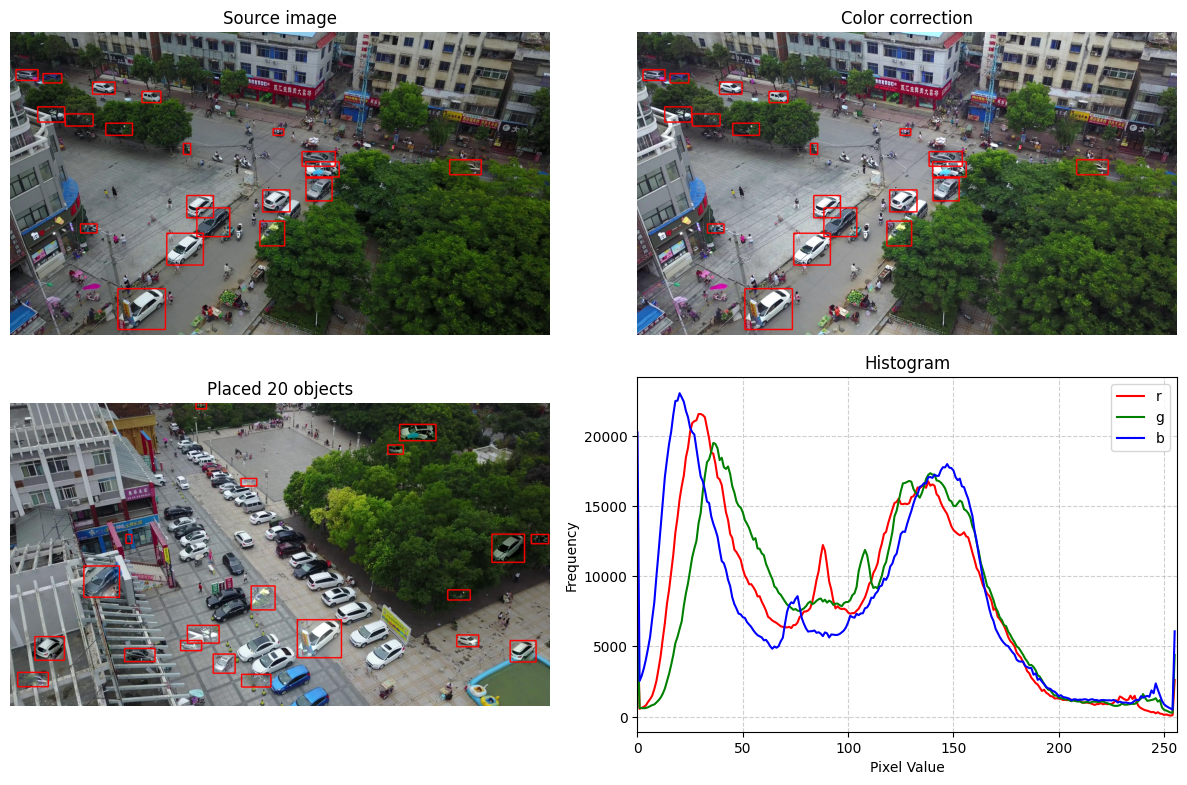

Initial image contains 20 objects


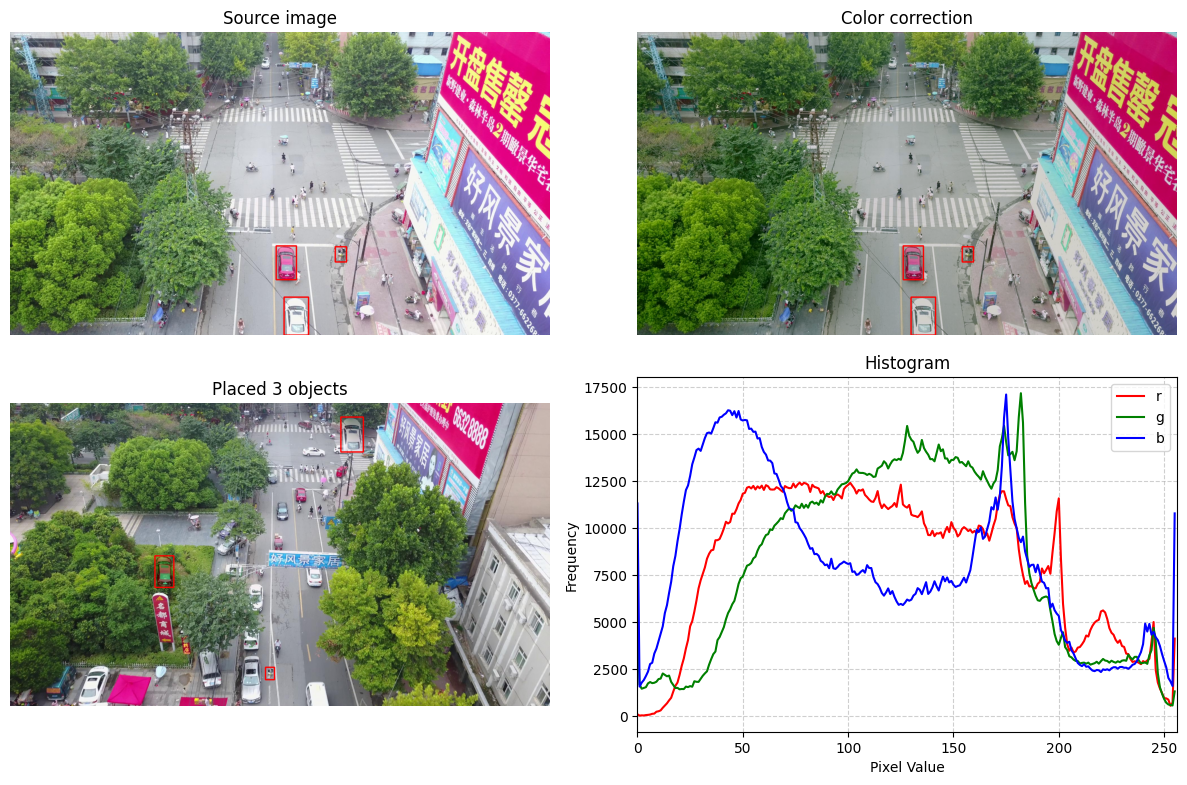

Initial image contains 3 objects


In [56]:
for img, annotations, count in loader:
  print(f'Initial image contains {int(count)} objects')